In [39]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#tutorial followed 
#https://towardsdatascience.com/energy-consumption-time-series-forecasting-with-python-and-lstm-deep-learning-model-7952e2f9a796

In [40]:
holidata = pd.read_pickle('./building4_holidays_sorted.pkl')
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 75832 entries, 2018-01-06 00:00:00 to 2020-12-06 23:45:00
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Valeur       75832 non-null  float64       
 1   Datetime     75832 non-null  datetime64[ns]
 2   working day  75832 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 1.8 MB


In [41]:
# we encode cynical data into two dimensions using a sine and cosine transformations
holidata['hour of day'] = holidata.index.hour
holidata['day of week'] = holidata.index.dayofweek
holidata['month'] = holidata.index.month
holidata['minutes'] = holidata.index.minute
holidata.head()

,Valeur,Datetime,working day,hour of day,day of week,month,minutes
Date,,,,,,,
2018-01-06 00:00:00,6.180,2018-01-06 00:00:00,False,0,5,1,0
2018-01-06 00:15:00,5.954,2018-01-06 00:15:00,False,0,5,1,15
2018-01-06 00:30:00,5.929,2018-01-06 00:30:00,False,0,5,1,30
2018-01-06 00:45:00,6.054,2018-01-06 00:45:00,False,0,5,1,45
2018-01-06 01:00:00,5.979,2018-01-06 01:00:00,False,1,5,1,0


In [42]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data
holidata = encode(holidata, 'hour of day', 23)
holidata = encode(holidata, 'day of week', 6)
holidata = encode(holidata, 'month', 12)
holidata = encode(holidata, 'minutes', 60)
holidata.head()

,Valeur,Datetime,working day,hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos
Date,,,,,,,,,,,,,,,
2018-01-06 00:00:00,6.180,2018-01-06 00:00:00,False,0,5,1,0,0.000000,1.000000,-0.866025,0.5,0.5,0.866025,0.000000e+00,1.000000e+00
2018-01-06 00:15:00,5.954,2018-01-06 00:15:00,False,0,5,1,15,0.000000,1.000000,-0.866025,0.5,0.5,0.866025,1.000000e+00,2.832769e-16
2018-01-06 00:30:00,5.929,2018-01-06 00:30:00,False,0,5,1,30,0.000000,1.000000,-0.866025,0.5,0.5,0.866025,5.665539e-16,-1.000000e+00
2018-01-06 00:45:00,6.054,2018-01-06 00:45:00,False,0,5,1,45,0.000000,1.000000,-0.866025,0.5,0.5,0.866025,-1.000000e+00,-1.836970e-16
2018-01-06 01:00:00,5.979,2018-01-06 01:00:00,False,1,5,1,0,0.269797,0.962917,-0.866025,0.5,0.5,0.866025,0.000000e+00,1.000000e+00


In [43]:
holidata = holidata[:'2019']

In [44]:
holidata['Datetime'] = pd.to_datetime(holidata['Datetime'])
holidata.index = holidata['Datetime']
holidata = holidata.drop_duplicates(subset=['Datetime'])
holidata = holidata.sort_index()
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58363 entries, 2018-01-06 00:00:00 to 2019-12-31 23:45:00
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Valeur           58363 non-null  float64       
 1   Datetime         58363 non-null  datetime64[ns]
 2   working day      58363 non-null  bool          
 3   hour of day      58363 non-null  int64         
 4   day of week      58363 non-null  int64         
 5   month            58363 non-null  int64         
 6   minutes          58363 non-null  int64         
 7   hour of day_sin  58363 non-null  float64       
 8   hour of day_cos  58363 non-null  float64       
 9   day of week_sin  58363 non-null  float64       
 10  day of week_cos  58363 non-null  float64       
 11  month_sin        58363 non-null  float64       
 12  month_cos        58363 non-null  float64       
 13  minutes_sin      58363 non-null  float64       
 14  min

In [45]:
holidata.tail()

,Valeur,Datetime,working day,hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos
Datetime,,,,,,,,,,,,,,,
2019-12-31 22:45:00,8.366,2019-12-31 22:45:00,True,22,1,12,45,-2.697968e-01,0.962917,0.866025,0.5,-2.449294e-16,1.0,-1.000000e+00,-1.836970e-16
2019-12-31 23:00:00,8.039,2019-12-31 23:00:00,True,23,1,12,0,-2.449294e-16,1.000000,0.866025,0.5,-2.449294e-16,1.0,0.000000e+00,1.000000e+00
2019-12-31 23:15:00,7.134,2019-12-31 23:15:00,True,23,1,12,15,-2.449294e-16,1.000000,0.866025,0.5,-2.449294e-16,1.0,1.000000e+00,2.832769e-16
2019-12-31 23:30:00,7.813,2019-12-31 23:30:00,True,23,1,12,30,-2.449294e-16,1.000000,0.866025,0.5,-2.449294e-16,1.0,5.665539e-16,-1.000000e+00
2019-12-31 23:45:00,7.511,2019-12-31 23:45:00,True,23,1,12,45,-2.449294e-16,1.000000,0.866025,0.5,-2.449294e-16,1.0,-1.000000e+00,-1.836970e-16


In [46]:
# Deep learning: 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
import itertools

class DeepModelTS():
    """
    A class to create a deep time series model
    """
    def __init__(
        self, 
        data: pd.DataFrame, 
        Y_var: str,
        holi_var: str,
        time_var: str,
        hour_var_sin: str,
        hour_var_cos: str,
        day_week_sin: str,
        day_week_cos: str,
        month_sin: str,
        month_cos: str,
        minutes_sin: str,
        minutes_cos: str,
        lag: int,
        LSTM_layer_depth: int, 
        epochs=10, 
        batch_size=256,
        train_test_split=0
    ):

        self.data = data 
        self.Y_var = Y_var 
        self.holi_var = holi_var
        self.time_var = time_var
        self.hour_var_sin = hour_var_sin
        self.hour_var_cos = hour_var_cos
        self.day_week_sin = day_week_sin
        self.day_week_cos = day_week_cos
        self.month_sin = month_sin
        self.month_cos = month_cos
        self.minutes_sin = minutes_sin
        self.minutes_cos = minutes_cos
        self.lag = lag 
        self.LSTM_layer_depth = LSTM_layer_depth
        self.batch_size = batch_size
        self.epochs = epochs
        self.train_test_split = train_test_split

    @staticmethod
    def create_X_Y(ts: list, datetime: list, holiday: list, hour_cos: list, hour_sin: list, week_cos: list, week_sin: list, month_cos: list, month_sin: list, minute_cos: list, minute_sin: list, lag: int) -> tuple:
        """
        A method to create X and Y matrix from a time series list for the training of 
        deep learning models 
        """
        X, Y = [], []
        

        if len(ts) - lag <= 0:
            X.append(ts)
        else:
            for i in range(len(ts) - lag):
                Y.append(ts[i + lag])
                # Substacted 96 for not knowing the day before
                ab = list(itertools.chain([ts[i+lag - 96]], [holiday[i + lag]], [hour_cos[i + lag]], [hour_sin[i + lag]], [week_cos[i + lag]], [week_sin[i + lag]], [month_cos[i + lag]], [month_sin[i + lag]], [minute_cos[i + lag]], [minute_sin[i + lag]]))
                X.append(ab)
                #X.append(ts[i:(i + lag - 96)] + [holiday[i + lag]] + [hour_cos[i + lag]] + [hour_sin[i + lag]] + )
                #X.append(datetime[i + lag])
                #X.append(holiday[i + lag])
                #X.append(hour_cos[i + lag])
                #X.append(hour_sin[i + lag])
                #X.append(week_cos[i + lag])
                #X.append(week_sin[i + lag])
                #X.append(month_cos[i + lag])
                #X.append(month_sin[i + lag])
      
        
        """
        for i in range(len(ts)):
            Y.append(ts[i])
            X.append(datetime[i])
            X.append(holiday[i])
            X.append(hour_cos[i])
            X.append(hour_sin[i])
            X.append(week_cos[i])
            X.append(week_sin[i])
            X.append(month_cos[i])
            X.append(month_sin[i]) 
        """
        
        X, Y = np.array(X), np.array(Y)

        # Reshaping the X array to an LSTM input shape 
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))

        return X, Y         

    def create_data_for_NN(
        self,
        use_last_n=None
        ):
        """
        A method to create data for the neural network model
        """
        # Extracting the main variable we want to model/forecast
        y = self.data[self.Y_var].tolist()
        y_datetime = self.data[self.time_var].tolist()
        y_holiday = self.data[self.holi_var].tolist()
        y_hour_cos = self.data[self.hour_var_cos].tolist()
        y_hour_sin = self.data[self.hour_var_sin].tolist()
        y_weekday_cos = self.data[self.day_week_cos].tolist()
        y_weekday_sin = self.data[self.day_week_sin].tolist()
        y_month_cos = self.data[self.month_cos].tolist()
        y_month_sin = self.data[self.month_sin].tolist()
        y_minute_cos = self.data[self.minutes_cos].tolist()
        y_minute_sin = self.data[self.minutes_sin].tolist()
        



        # Subseting the time series if needed
        if use_last_n is not None:
            y = y[-use_last_n:]

        # The X matrix will hold the lags of Y 
        X, Y = self.create_X_Y(y, y_datetime, y_holiday, y_hour_cos, y_hour_sin, y_weekday_cos, y_weekday_sin, y_month_cos, y_month_sin, y_minute_cos, y_minute_sin, self.lag)

        # Creating training and test sets 
        X_train = X
        X_test = []

        Y_train = Y
        Y_test = []

        if self.train_test_split > 0:
            index = round(len(X) * self.train_test_split)
            X_train = X[:(len(X) - index)]
            X_test = X[-index:]     
            
            Y_train = Y[:(len(X) - index)]
            Y_test = Y[-index:]
        print(X_train.shape)
        return X_train, X_test, Y_train, Y_test

    def LSTModel(self):
        """
        A method to fit the LSTM model 
        """
        # Getting the data 
        X_train, X_test, Y_train, Y_test = self.create_data_for_NN()
        print(X_train.shape)
        # Defining the model
        model = Sequential()
        model.add(LSTM(self.LSTM_layer_depth, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        
        # Setting up early stopping
        earlyStop=EarlyStopping(monitor="val_loss",verbose=2,mode='min',patience=3)
        
        # Saving training history
        csv_logger = CSVLogger('training_B2_25ep.log', separator=',', append=False)
        
        # Defining the model parameter dict 
        keras_dict = {
            'x': X_train,
            'y': Y_train,
            'batch_size': self.batch_size,
            'epochs': self.epochs,
            'shuffle': False,
            #'callbacks': [earlyStop, csv_logger]
            'callbacks': [csv_logger]

        }

        if self.train_test_split > 0:
            keras_dict.update({
                'validation_data': (X_test, Y_test)
            })

        # Fitting the model 
        model.fit(
            **keras_dict
        )

        # Saving the model to the class 
        self.model = model

        return model

    def predict(self) -> list:
        """
        A method to predict using the test data used in creating the class
        """
        yhat = []

        if(self.train_test_split > 0):
        
            # Getting the last n time series 
            _, X_test, _, _ = self.create_data_for_NN()        

            # Making the prediction list 
            yhat = [y[0] for y in self.model.predict(X_test)]

        return yhat

    def predict_n_ahead(self, n_ahead: int):
        """
        A method to predict n time steps ahead
        """    
        X, _, _, _ = self.create_data_for_NN(use_last_n=self.lag)        

        # Making the prediction list 
        yhat = []

        for _ in range(n_ahead):
            # Making the prediction
            fc = self.model.predict(X)
            yhat.append(fc)

            # Creating a new input matrix for forecasting
            X = np.append(X, fc)

            # Ommiting the first variable
            X = np.delete(X, 0)

            # Reshaping for the next iteration
            X = np.reshape(X, (1, len(X), 1))

        return yhat    

In [49]:
deep_learner = DeepModelTS(
data = holidata,
Y_var = 'Valeur',
holi_var = 'working day',
time_var = 'Datetime',
hour_var_sin = 'hour of day_sin',
hour_var_cos = 'hour of day_cos',
day_week_sin = 'day of week_sin',
day_week_cos = 'day of week_cos',
month_sin = 'month_sin',
month_cos = 'month_cos',
minutes_sin = 'minutes_sin',
minutes_cos = 'minutes_cos',
lag = 96,
LSTM_layer_depth = 50,
epochs = 50,
batch_size = 128,
train_test_split = 0.15
)

In [50]:
# Fitting the model
model = deep_learner.LSTModel ()

(49527, 10, 1)
(49527, 10, 1)
Epoch 1/50
387/387 [==============================] - 7s 17ms/step - loss: 13.5543 - val_loss: 6.4121
Epoch 2/50
387/387 [==============================] - 7s 19ms/step - loss: 7.1924 - val_loss: 6.1950
Epoch 3/50
387/387 [==============================] - 8s 20ms/step - loss: 6.8738 - val_loss: 5.7216
Epoch 4/50
387/387 [==============================] - 8s 19ms/step - loss: 6.5434 - val_loss: 5.2196
Epoch 5/50
387/387 [==============================] - 7s 19ms/step - loss: 6.1494 - val_loss: 4.7606
Epoch 6/50
387/387 [==============================] - 8s 21ms/step - loss: 5.7166 - val_loss: 4.3895
Epoch 7/50
387/387 [==============================] - 8s 21ms/step - loss: 5.4093 - val_loss: 4.2357
Epoch 8/50
387/387 [==============================] - 8s 22ms/step - loss: 5.2018 - val_loss: 4.1478
Epoch 9/50
387/387 [==============================] - 8s 20ms/step - loss: 5.0151 - val_loss: 4.0927
Epoch 10/50
387/387 [==============================] - 6s 17

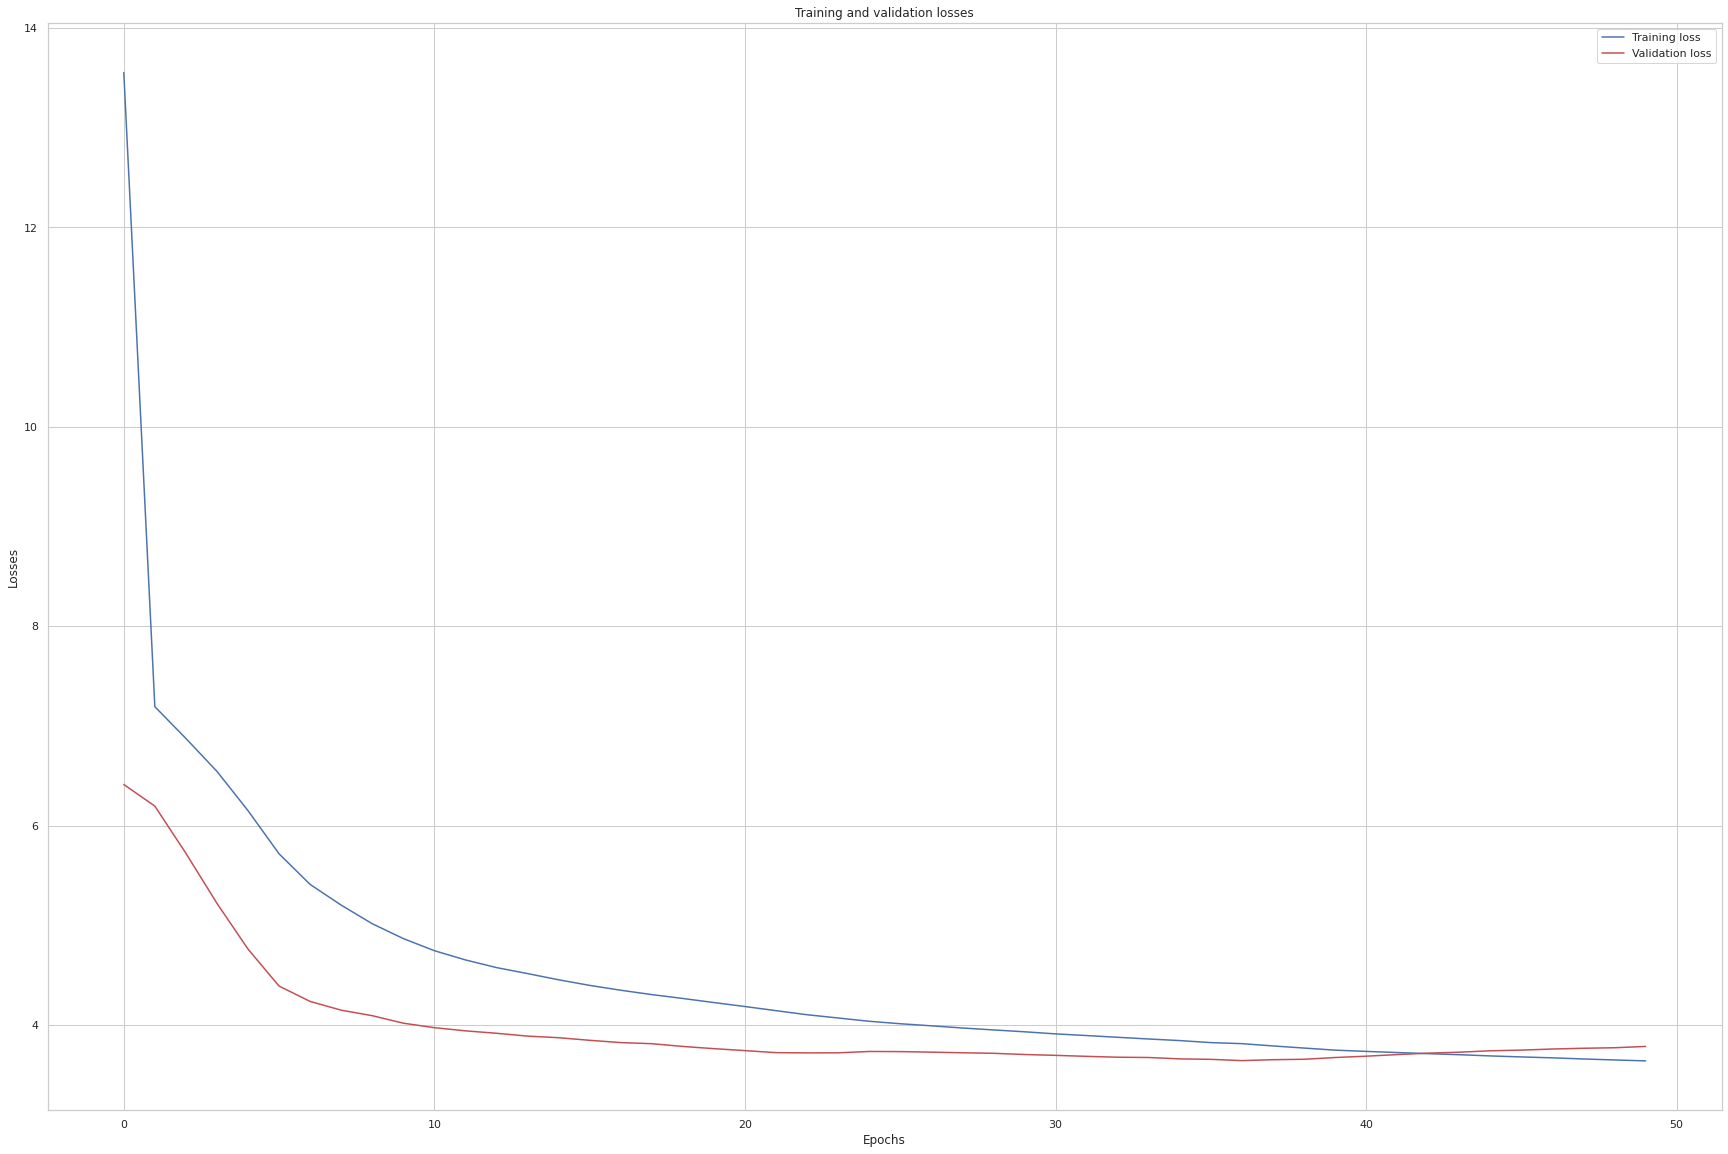

In [51]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']

    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    #plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show()  
plot_train_history(model)

In [52]:
model_json = model.to_json()
with open("model_96_B4_no2020_ep50.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_96_B4_no2020_ep50.h5")

(49527, 10, 1)


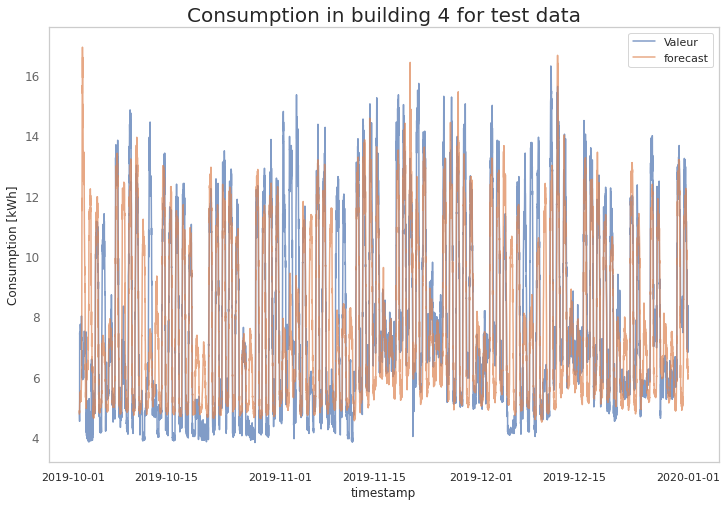

In [72]:
yhat = deep_learner.predict()# Constructing the forecast dataframe
#fc = holidata.nlargest(len(yhat),columns='Datetime').copy()
fc = holidata.tail(len(yhat)).copy()
fc['forecast'] = yhat
#fc['Datetime'] = pd.to_datetime(fc['Datetime'])
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    plt.plot('Datetime',dtype,data=fc,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 4 for test data", fontsize=20)

plt.show()

In [54]:
fc.head()

,Valeur,Datetime,working day,hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos,forecast
Datetime,,,,,,,,,,,,,,,,
2019-10-01 23:00:00,4.798,2019-10-01 23:00:00,True,23,1,10,0,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,0.000000e+00,1.000000e+00,4.760925
2019-10-01 23:15:00,4.773,2019-10-01 23:15:00,True,23,1,10,15,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,1.000000e+00,2.832769e-16,4.881206
2019-10-01 23:30:00,4.547,2019-10-01 23:30:00,True,23,1,10,30,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,5.665539e-16,-1.000000e+00,4.805052
2019-10-01 23:45:00,4.522,2019-10-01 23:45:00,True,23,1,10,45,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,-1.000000e+00,-1.836970e-16,4.949881
2019-10-02 00:00:00,7.461,2019-10-02 00:00:00,True,0,2,10,0,0.000000e+00,1.0,0.866025,-0.5,-0.866025,0.5,0.000000e+00,1.000000e+00,5.224350


In [55]:
fc = fc.set_index('Datetime', drop=False)
fc.index = pd.to_datetime(fc.index)
fc.head()

,Valeur,Datetime,working day,hour of day,day of week,month,minutes,hour of day_sin,hour of day_cos,day of week_sin,day of week_cos,month_sin,month_cos,minutes_sin,minutes_cos,forecast
Datetime,,,,,,,,,,,,,,,,
2019-10-01 23:00:00,4.798,2019-10-01 23:00:00,True,23,1,10,0,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,0.000000e+00,1.000000e+00,4.760925
2019-10-01 23:15:00,4.773,2019-10-01 23:15:00,True,23,1,10,15,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,1.000000e+00,2.832769e-16,4.881206
2019-10-01 23:30:00,4.547,2019-10-01 23:30:00,True,23,1,10,30,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,5.665539e-16,-1.000000e+00,4.805052
2019-10-01 23:45:00,4.522,2019-10-01 23:45:00,True,23,1,10,45,-2.449294e-16,1.0,0.866025,0.5,-0.866025,0.5,-1.000000e+00,-1.836970e-16,4.949881
2019-10-02 00:00:00,7.461,2019-10-02 00:00:00,True,0,2,10,0,0.000000e+00,1.0,0.866025,-0.5,-0.866025,0.5,0.000000e+00,1.000000e+00,5.224350


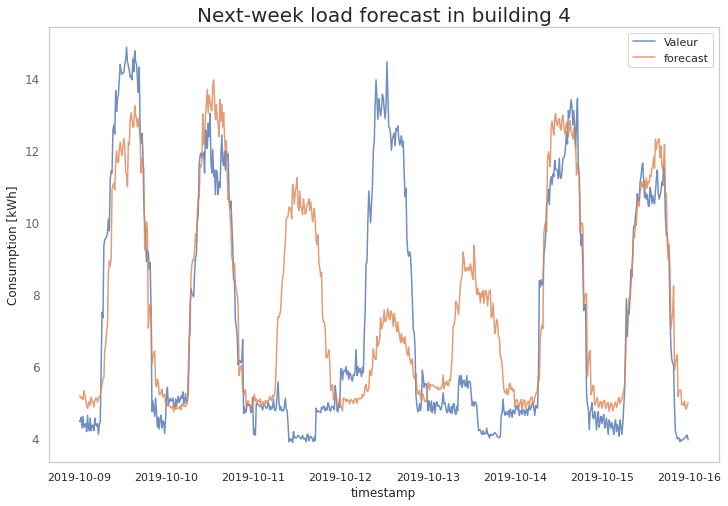

In [68]:
plt.figure(figsize=(12, 8))
for dtype in ['Valeur', 'forecast']:  
    #plt.plot('Datetime',dtype,data=fc['2019-07-15':'2019-07-21'],label=dtype,alpha=0.8)
    plt.plot('Datetime',dtype,data=fc['2019-10-09':'2019-10-15'],label=dtype,alpha=0.8)
    #plt.plot('Datetime',dtype,data=fc[:'2019'],label=dtype,alpha=0.8)
plt.legend()
plt.grid()

plt.rcParams.update({'figure.figsize': (30,20)})
plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Next-week load forecast in building 4", fontsize=20)

plt.show()

In [77]:
#need to MAPE, RMSE and R-correlation factor
#expected = fc.loc['2019-10-09':'2019-10-15','Valeur']
expected = fc.loc[:'2019','Valeur']
#predictions = fc.loc['2019-10-09':'2019-10-15','forecast']
predictions = fc.loc[:'2019','forecast']
forecast_errors = [expected[i]-predictions[i] for i in range(len(expected))]

In [78]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(expected, predictions)
rmse = sqrt(mse)
print('RMSE: %f [kWh]' % rmse)

RMSE: 1.945298 [kWh]


In [79]:
def mean_absolute_percentage_error(y_true, y_pred): 
    #y_true, y_pred = check_array(y_true, y_pred)
    np.isfinite(expected).any()
    np.isfinite(predictions).any()
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(np.array(expected), np.array(predictions))
print('MAPE: %f %%' % mape)

MAPE: 19.384008 %


/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/evgeny/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0, 0.5, 'MAPE %')]

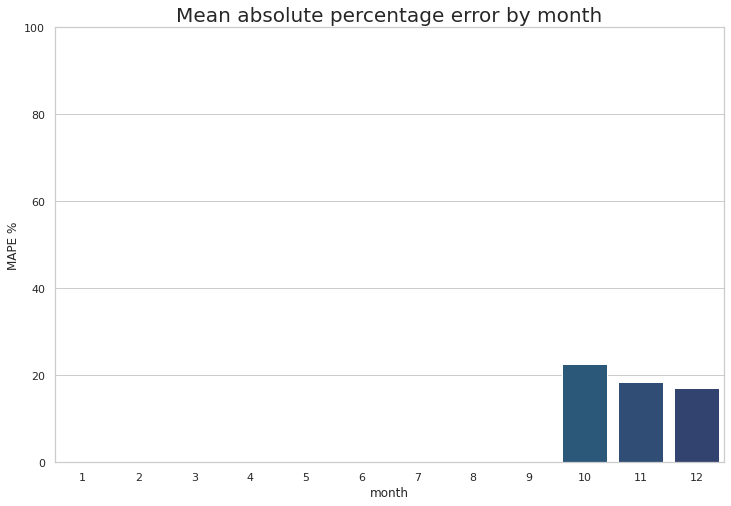

In [80]:
mape = []
for i in range(1,13):
    expected = fc['Valeur'].loc[fc.index.month == i]
    predictions = fc['forecast'].loc[fc.index.month == i]
    mape.append(mean_absolute_percentage_error(np.array(expected), np.array(predictions)))
data_tuples = list(zip(list(range(1,13)), mape))
months = pd.DataFrame(data_tuples, columns=['month','MAPE'])
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
#sns.color_palette('rocket', as_cmap=True)
ax = sns.barplot(x='month', y='MAPE', data = months, palette='crest')
ax.set_ylim([0,100])
plt.title("Mean absolute percentage error by month", fontsize=20)
ax.set(ylabel='MAPE %')

In [45]:
holidata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209826 entries, 2014-01-06 02:00:00 to 2020-07-01 00:00:00
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Datetime     209826 non-null  datetime64[ns]
 1   Valeur       209826 non-null  float64       
 2   working day  209826 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1)
memory usage: 5.0 MB


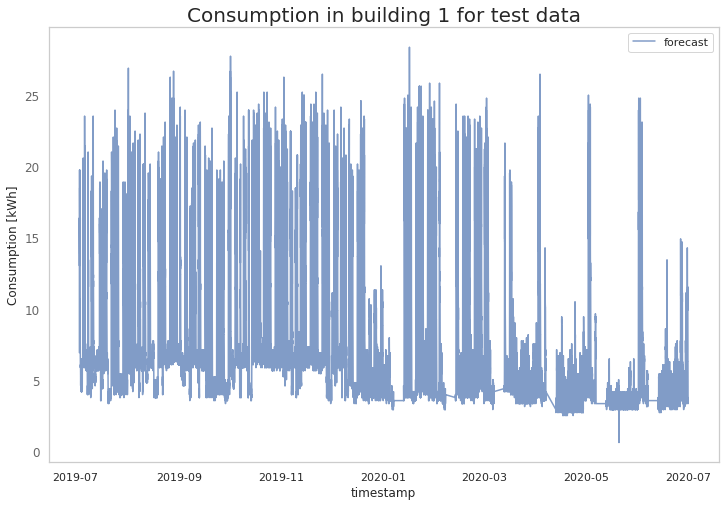

In [73]:
example = holidata.tail(len(yhat)).copy()
#example = holidata.nlargest(len(yhat),columns='Datetime').copy()
plt.figure(figsize=(12, 8))
plt.plot('Datetime','Valeur',data=example,label=dtype,alpha=0.7)
plt.legend()
plt.grid()

plt.gca().set(ylabel='Consumption [kWh]', xlabel='timestamp')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Consumption in building 1 for test data", fontsize=20)

plt.show()